In [11]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from data_loading import read_hackathon_data

from metrics.metrics_time import TimeMetrics
from itertools import product

df = pd.read_csv('../data/all_experiments-25-08.csv', index_col=0).reset_index()
df['task'] = 'task2'
df.loc[df.notebook_name.str.contains('task1'), 'task'] = 'task1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
TM = TimeMetrics()
metrics = TM.calculate_metrics(df)
metrics.head()
kernel_mapping  = metrics.loc[:, ['kernel_id', 'task', 'expert']].drop_duplicates()

# Execution time

In [3]:
# TODO:
# deal with missing execs
# metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].state_time_dt.isna().sum()

,index,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,labels,task,expert,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time
0,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,0 days 00:00:22.731000,2023-05-06 11:58:35.270,stream,0,162.0,22.731,22.731
1,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,162.0,NaN,4.652
2,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,0 days 00:00:00.822000,2023-05-06 11:59:02.653,stream,0,20.0,0.822,0.822
3,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,20.0,NaN,1.788
4,1118,2023-05-06 11:59:05.263,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,code,!pip install sklearn,...,"helper_functions,",task1,False,0 days 00:00:00.755000,2023-05-06 11:59:05.263,stream,0,20.0,0.755,0.755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20843,19742,2023-07-03 15:49:31.530,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,6e3d3614064748888cc82a221f924fd4,75.0,code,None,...,"comment_only,",task2,True,NaT,NaT,NaN,0,NaN,NaN,2.149
20844,19743,2023-07-03 15:49:33.679,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,execute,6e3d3614064748888cc82a221f924fd4,76.0,code,y_pred,...,"evaluation,",task2,True,0 days 00:00:00.144000,2023-07-03 15:49:33.679,execute_result,1,6.0,0.144,0.034
20845,19744,2023-07-03 15:49:33.713,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,30506d3f2fce44f18584f719e752d811,76.0,code,None,...,"comment_only,",task2,True,NaT,NaT,NaN,0,NaN,NaN,0.110
20846,19745,2023-07-03 15:49:33.823,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,finished_execute,6e3d3614064748888cc82a221f924fd4,77.0,code,y_pred,...,"evaluation,",task2,True,NaT,NaT,NaN,0,6.0,NaN,2.937


<Axes: xlabel='event', ylabel='next_action_time'>

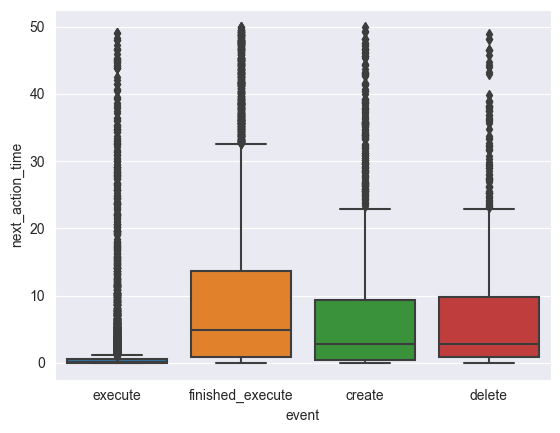

In [7]:
metrics.loc[metrics.event == 'execute', 'cell_index'].nunique(), len(metrics[metrics.event == 'execute'])

In [158]:
sum_exec = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'state_time_dt'].sum()).to_frame('exec_time_sum') / 60
sum_exec_count = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'state_time_dt'].count()).to_frame('exec_time_count')
sum_exec_mean = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'state_time_dt'].mean()).to_frame('exec_time_mean') / 60
sum_all = metrics.groupby('kernel_id').next_action_time.sum().to_frame('overall_time') / 60

kernel_time_df = kernel_mapping.merge(sum_exec, on = 'kernel_id').merge(sum_exec_mean, on = 'kernel_id').merge(sum_all, on = 'kernel_id').merge(sum_exec_count, on = 'kernel_id')
kernel_time_df['percent'] = kernel_time_df.exec_time_sum / kernel_time_df.overall_time * 100
kernel_time_df['exec_time_n'] = kernel_time_df.exec_time_sum / kernel_time_df.exec_time_count
exec_comp = kernel_time_df.groupby(['task', 'expert']).describe()

(1963, 9207)

In [159]:
cols = list(product(['exec_time_sum', 'percent','exec_time_n'],['mean', 'std']))
lop = exec_comp.loc[:,cols]
print(lop.round(2).applymap('{:.2f}'.format).to_latex(escape = True, multirow=True))


,index,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,labels,task,expert,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time
0,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,0 days 00:00:22.731000,2023-05-06 11:58:35.270,stream,0,162.0,22.731,22.731
1,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,162.0,NaN,4.652
2,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,0 days 00:00:00.822000,2023-05-06 11:59:02.653,stream,0,20.0,0.822,0.822
3,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,20.0,NaN,1.788
4,1118,2023-05-06 11:59:05.263,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,code,!pip install sklearn,...,"helper_functions,",task1,False,0 days 00:00:00.755000,2023-05-06 11:59:05.263,stream,0,20.0,0.755,0.755


In [160]:
execs = metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].dropna()

In [161]:
execs.anova(dv="state_time_dt", between=["expert", "task"]).round(3)

\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{exec\_time\_sum} & \multicolumn{2}{r}{percent} & \multicolumn{2}{r}{exec\_time\_n} \\
 &  & mean & std & mean & std & mean & std \\
task & expert &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 15.49 & 13.89 & 7.60 & 8.48 & 0.05 & 0.02 \\
 & True & 4.85 & 4.12 & 2.94 & 2.58 & 0.02 & 0.02 \\
\cline{1-8}
\multirow[t]{2}{*}{task2} & False & 28.61 & 27.40 & 11.87 & 9.52 & 0.12 & 0.08 \\
 & True & 30.83 & 38.96 & 14.20 & 13.35 & 0.09 & 0.10 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [162]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

In [163]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,Source,SS,DF,MS,F,p-unc,np2
0,expert,6539.547,1.0,6539.547,6.476,0.011,0.001
1,task,36139.237,1.0,36139.237,35.787,0.000,0.004
2,expert * task,80.944,1.0,80.944,0.080,0.777,0.000
3,Residual,9063344.666,8975.0,1009.843,NaN,NaN,NaN


In [164]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.46,16.83,two-sided,0.16,"[-33.81, 185.78]",0.51,0.868,0.15


# Action time

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.67,10,two-sided,0.52,"[-0.08, 0.15]",0.39,0.54,0.09


In [167]:
metrics = metrics[metrics.notebook_name.isin(['task1.ipynb', 'task2.ipynb'])]

labels
comment_only,                               0.706887
data_exploration,                           1.993690
data_exploration,modelling,                 0.907250
data_exploration,result_visualization,      1.307600
data_preprocessing,                         2.941622
data_preprocessing,data_exploration,        4.355762
evaluation,                                 0.075000
helper_functions,                           3.816076
helper_functions,data_exploration,          0.432889
helper_functions,data_preprocessing,        1.681864
helper_functions,evaluation,                0.125865
helper_functions,load_data,                 5.378083
helper_functions,modelling,                24.487443
load_data,                                  0.643182
load_data,data_exploration,                 0.599867
modelling,                                 23.950961
modelling,evaluation,                     115.759000
prediction,                                 0.540155
result_visualization,                  

In [168]:
metrics_long =  metrics.loc[:,['notebook_name','event','expert','next_action_time', 'interruptions', 'state_time_dt']]

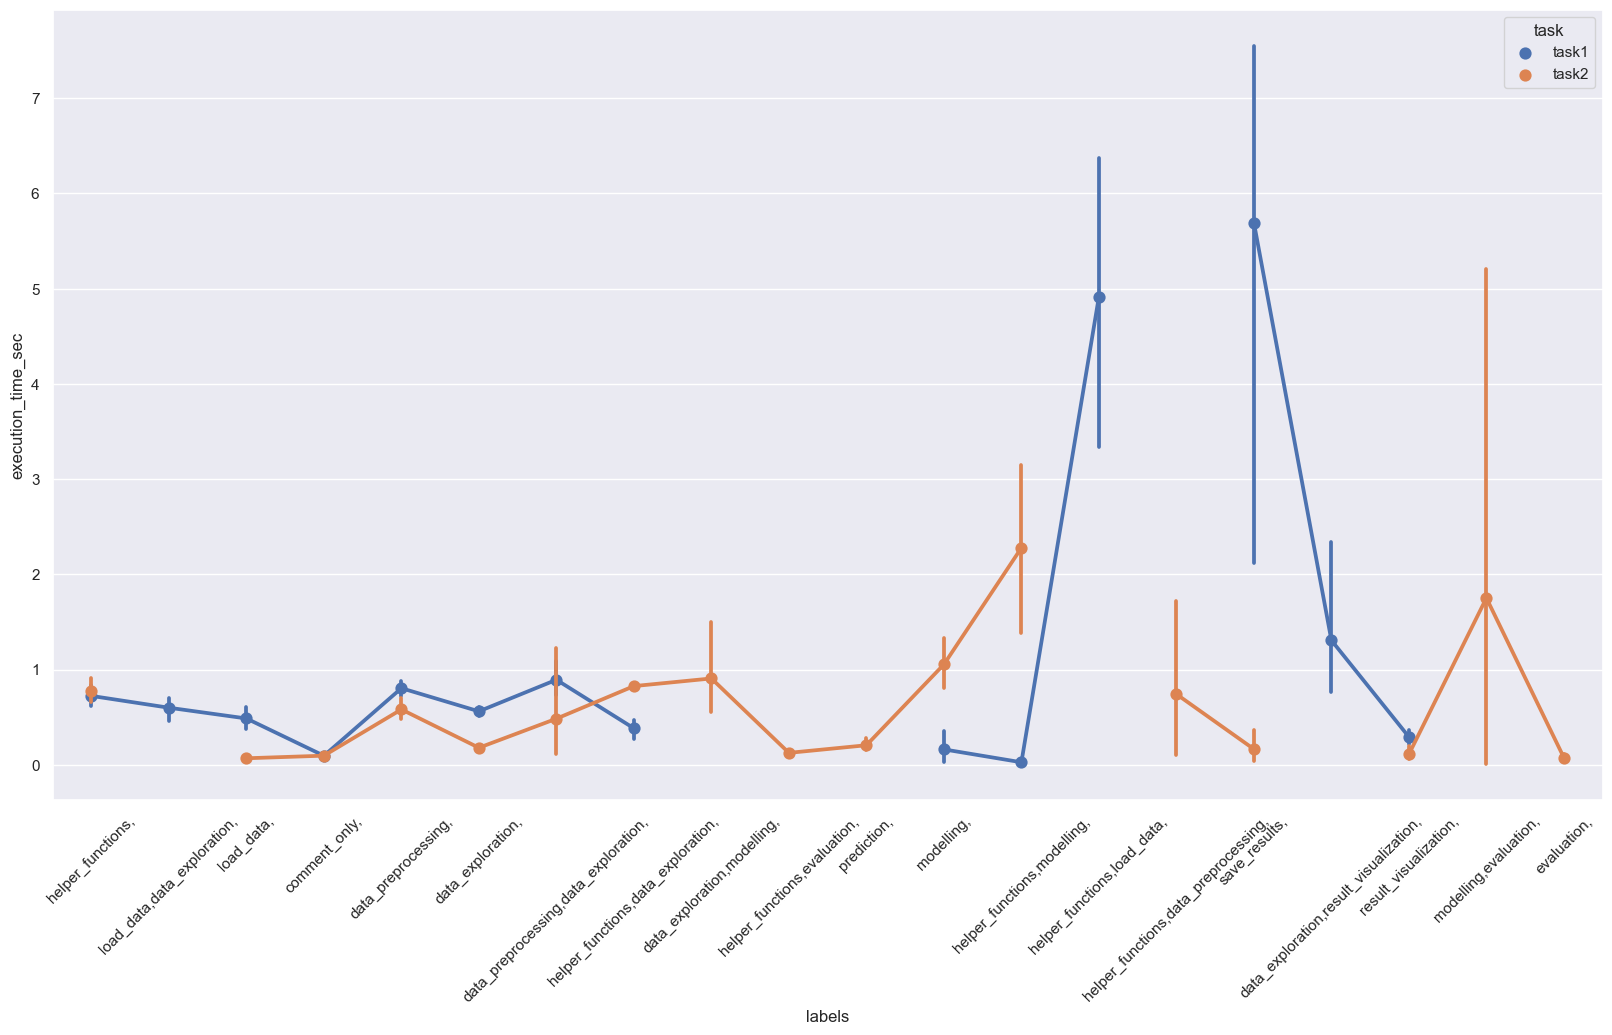

In [169]:
metrics_long = metrics_long.melt(id_vars=['notebook_name','event','expert', 'state_time_dt'])

In [171]:
interruptions = metrics_long[(metrics_long.variable == 'interruptions')&(metrics_long.event == 'execute')]

,index,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,labels,task,expert,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time
0,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,0 days 00:00:22.731000,2023-05-06 11:58:35.270,stream,0,162.0,22.731,22.731
1,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,162.0,NaN,4.652
2,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,0 days 00:00:00.822000,2023-05-06 11:59:02.653,stream,0,20.0,0.822,0.822
3,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,20.0,NaN,1.788
4,1118,2023-05-06 11:59:05.263,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,code,!pip install sklearn,...,"helper_functions,",task1,False,0 days 00:00:00.755000,2023-05-06 11:59:05.263,stream,0,20.0,0.755,0.755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20843,19742,2023-07-03 15:49:31.530,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,6e3d3614064748888cc82a221f924fd4,75.0,code,None,...,"comment_only,",task2,True,NaT,NaT,NaN,0,NaN,NaN,2.149
20844,19743,2023-07-03 15:49:33.679,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,execute,6e3d3614064748888cc82a221f924fd4,76.0,code,y_pred,...,"evaluation,",task2,True,0 days 00:00:00.144000,2023-07-03 15:49:33.679,execute_result,1,6.0,0.144,0.034
20845,19744,2023-07-03 15:49:33.713,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,30506d3f2fce44f18584f719e752d811,76.0,code,None,...,"comment_only,",task2,True,NaT,NaT,NaN,0,NaN,NaN,0.110
20846,19745,2023-07-03 15:49:33.823,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,finished_execute,6e3d3614064748888cc82a221f924fd4,77.0,code,y_pred,...,"evaluation,",task2,True,NaT,NaT,NaN,0,6.0,NaN,2.937


# Action time

In [178]:
tips = sns.load_dataset("tips")

In [182]:
interruptions

In [142]:
interruptions.columns

In [193]:
g = sns.FacetGrid(interruptions, col="notebook_name",  row="expert")
g.map(sns.scatterplot, "state_time_dt", "value")

,index,cell_source,cell_index,interruptions,time,nb_lens,cell_num
10501,23479,import zipfile\n\n\nz = zipfile.ZipFile('data/...,9192ba25ad544abcb897fd1e614f317b,23,2023-08-18 15:47:56.037,32,1.0
10429,23404,# # Do not forget to check if your notebook lo...,f160b7e6629c4a528621a4e25acfa15f,23,2023-08-18 15:44:14.553,32,0.0
17764,19688,# # Do not forget to check if your notebook lo...,80f0719433b44210af107865b1473fea,23,2023-07-03 15:45:57.446,29,27.0
8503,23144,# # Do not forget to check if your notebook lo...,4a3c9d0c6c374b919a65e15dce717b1c,21,2023-08-18 15:01:20.538,31,21.0
16525,16287,# # Do not forget to check if your notebook lo...,b2a02197770e444a899c8ecc0b540f7d,20,2023-05-22 15:03:39.500,29,24.0
...,...,...,...,...,...,...,...
7089,5046,deltas.shape,f5b9f39019974515848c23de6b11cfb7,0,2023-05-06 14:40:09.259,14,24.0
7088,5045,deltas.shape,f5b9f39019974515848c23de6b11cfb7,0,2023-05-06 14:40:09.226,14,24.0
7087,5044,deltas.shape,f5b9f39019974515848c23de6b11cfb7,0,2023-05-06 14:40:08.010,14,24.0
7086,5043,deltas.shape,f5b9f39019974515848c23de6b11cfb7,0,2023-05-06 14:40:07.970,14,24.0


In [194]:
metrics.loc[:, ['next_action_time', 'event']].groupby('event').describe()

,state_num,cell_index,cell_num,cell_source,index,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,labels,task,expert,action_id
0,1324,99729046534a4b15a305c862060a8837,0.0,!pip install pandas\n!pip install np\n!pip ins...,8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
1,1324,11c9baa0ae044c468fa218ac2c6ca932,1.0,import pandas as pd\nimport numpy as np\nimpor...,8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
2,1324,4de9e4c7d0b9434f942f1395f520a834,2.0,None,8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
3,1324,ce25dd5fd9364e48872e1186aa51e3ee,3.0,"PATH_TO_DATA = ""./data/task1/jetnet_logs/jetne...",8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
4,1324,c9cf26479fa744ee83f2fea0a65f22c6,4.0,"PATH_TO_DATA = ""./data/task1/jetnet_logs/jetne...",8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
5,1324,a5eaa558afc74fa5b321503bef5124db,5.0,"df.sort_values(""action_time"")",8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
6,1324,5e12602a43244dfb859d9f629f11695a,6.0,"PATH_TO_DATA = ""./data/task1/jetnet_logs/jetne...",8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
7,1324,331b6bdd45a84071892e5ae4bde79ffc,8.0,"df = df.dropna()\ndf.groupby(""user_id"").count(...",8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
8,1324,84d88d7d2739477982cff5e754b3f151,9.0,"df.sort_values(""action_time"")",8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0
9,1324,f51821122e594d178ed873e614c162d9,10.0,None,8411.0,2023-05-06 16:28:49.750,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"data_exploration,",task1,False,8411.0


In [148]:
metrics[(metrics.next_action_time > 60*5)]
# clean_metrics = metrics[~(metrics.state_time_dt > 60*100)]


Index(['index', 'time', 'session_id', 'kernel_id_x', 'notebook_name', 'event',
       'cell_index', 'cell_num', 'cell_type', 'cell_source', 'cell_output',
       'user_id', 'labels', 'task', 'expert', 'execution_time',
       'execution_start', 'result', 'interruptions', 'src_len',
       'execution_time_sec', 'next_action_time', 'current_nb_len',
       'kernel_id_y', 'nb_len'],
      dtype='object')